In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import sys
sys.path.append("..")
from dpa.dpa_fit import MDDPA
from sklearn.model_selection import train_test_split

import umap

/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n = 1000
x_tr, color_tr = datasets.make_s_curve(n, noise=0.1, random_state=22)
#x_te, color_te = datasets.make_s_curve(n, noise=0.1, random_state=222)

In [3]:
def plot_3d(points, points_color=None, title=None, save_dir=None):
    x, y, z = points.T
    fig, ax = plt.subplots(
        figsize=(5, 5),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    if title is not None:
        fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    if save_dir is not None:
        plt.savefig(save_dir, bbox_inches='tight')
    plt.show()

In [4]:
x_tr = torch.Tensor(x_tr)
u = umap.UMAP(n_components=2, random_state = 42)
z_tr = u.fit_transform(x_tr)

/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [25]:
x_tr, x_te, z_tr, z_te, color_tr, color_te = train_test_split(x_tr, torch.Tensor(z_tr), color_tr, test_size=0.33, random_state=42)

In [26]:
z_mean = torch.mean(z_tr, dim=0)
z_std = torch.std(z_tr, dim=0)
z_std[z_std == 0] += 1e-5
x_tr = (z_tr - z_mean) / z_std
z_mean = z_mean.to(device)
z_std = z_std.to(device)

In [27]:
dpa = MDDPA(data_dim=3, latent_dims=[3,2,1,0], num_layer=8, hidden_dim=500, coef_distill_latent=1e2, noise_dim=2, device=device)

Running on CPU.



/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


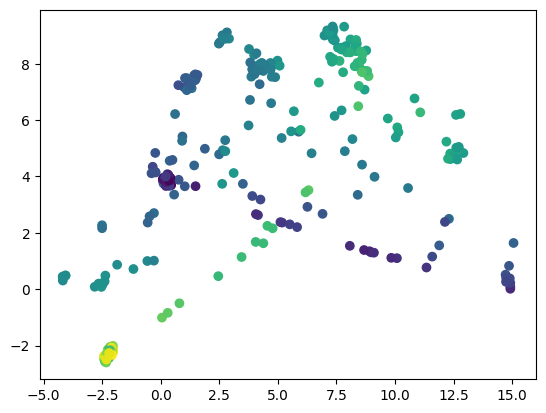

In [28]:
z_tr = u.transform(x_tr)
plt.scatter(z_tr[:, 0], z_tr[:, 1], c=color_tr)

In [ ]:
dpa.train(x_tr, z_tr, batch_size=250, num_epochs=1000)

Start training with 3 batches each of size 250.

[Epoch 1] 1.7650, 1.5884, 1.5105, 1.4715
 pred 	1.8603, 1.8373, 1.7887, 1.7881
 var 	0.1907, 0.4977, 0.5565, 0.6332

[Epoch 100] 0.2133, 0.2457, 0.5641, 1.0903
 pred 	0.4395, 0.5756, 1.1619, 2.1043
 var 	0.4524, 0.6598, 1.1956, 2.0280

[Epoch 200] 0.1744, 0.2113, 0.5386, 1.0757
 pred 	0.3463, 0.4795, 1.0625, 2.1459
 var 	0.3438, 0.5363, 1.0478, 2.1403

[Epoch 300] 0.1508, 0.1884, 0.4726, 1.0808
 pred 	0.2807, 0.4023, 1.0085, 2.1856
 var 	0.2598, 0.4279, 1.0718, 2.2096

[Epoch 400] 0.1254, 0.1687, 0.5040, 1.1431
 pred 	0.2489, 0.3703, 1.0102, 2.1526
 var 	0.2471, 0.4033, 1.0124, 2.0190

[Epoch 500] 0.1071, 0.1452, 0.4861, 1.1216
 pred 	0.2245, 0.3361, 0.9709, 2.1768
 var 	0.2348, 0.3818, 0.9696, 2.1105

[Epoch 600] 0.1225, 0.1520, 0.4369, 1.1040
 pred 	0.2373, 0.3340, 0.9247, 2.1400
 var 	0.2297, 0.3640, 0.9756, 2.0719

[Epoch 700] 0.1019, 0.1230, 0.4489, 1.1362
 pred 	0.2111, 0.2899, 0.9137, 2.1555
 var 	0.2183, 0.3336, 0.9296, 2.0385

[

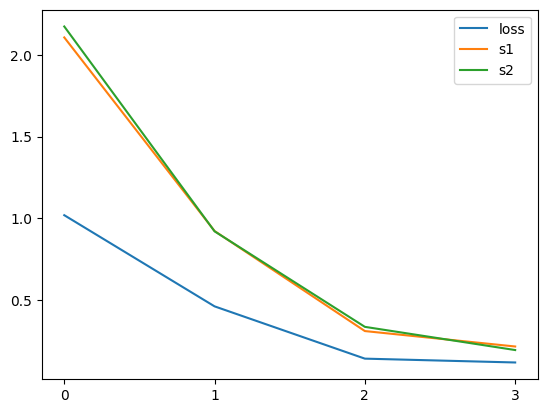

In [9]:
dpa.plot_energy_loss(x_te, xscale='linear')

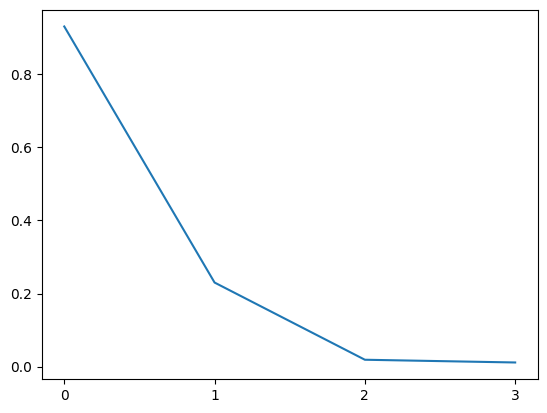

In [10]:
dpa.plot_mse(x_te, xscale='linear')

/var/folders/2q/4kcdg9gn3lbbjv6rtmgzglk00000gn/T/ipykernel_29917/1196440326.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  z_dpa = np.array(dpa.encode(x_te, k=2, gen_sample_size=1))


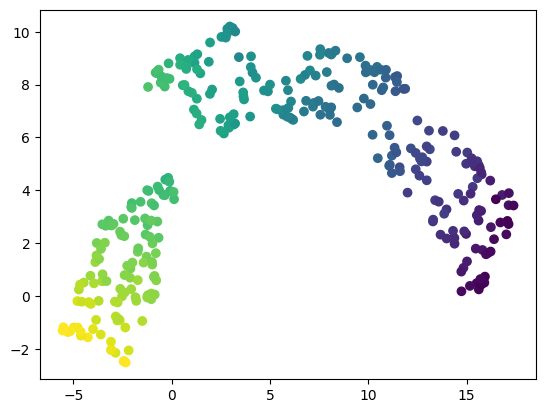

In [11]:
z_dpa = np.array(dpa.encode(x_te, k=2, gen_sample_size=1))

plt.scatter(z_dpa[:, 0], z_dpa[:, 1], c = color_te)


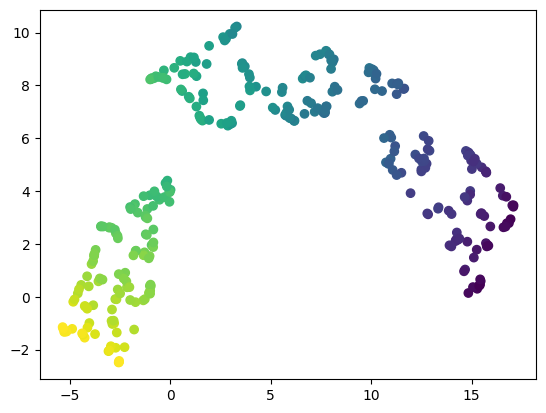

In [12]:
plt.scatter(z_te[:, 0], z_te[:, 1], c = color_te)

/var/folders/2q/4kcdg9gn3lbbjv6rtmgzglk00000gn/T/ipykernel_29917/1384225316.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  z_dpa = np.array(dpa.encode(x_tr, k=2, gen_sample_size=1))


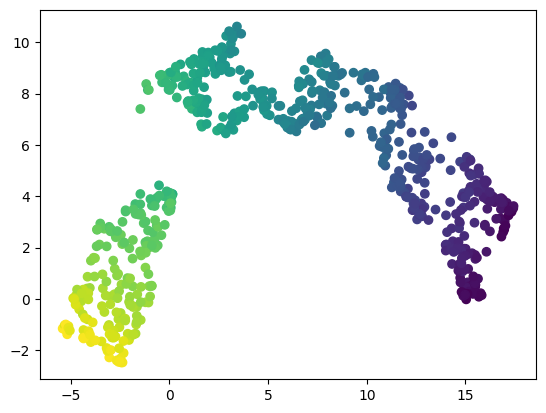

In [13]:
z_dpa = np.array(dpa.encode(x_tr, k=2, gen_sample_size=1))

plt.scatter(z_dpa[:, 0], z_dpa[:, 1], c = color_tr)


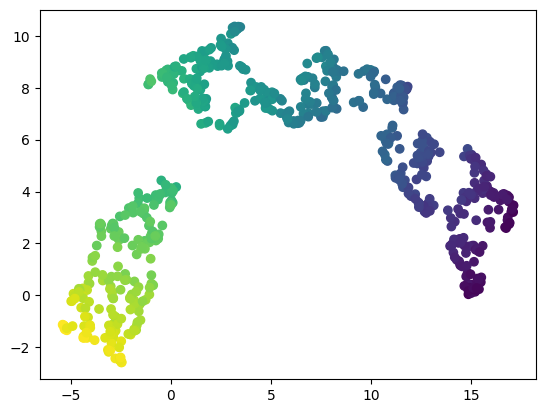

In [14]:
plt.scatter(z_tr[:, 0], z_tr[:, 1], c = color_tr)

In [15]:
np.mean((np.array(dpa.encode(x_te, k=2)) - z_te)**2)

/var/folders/2q/4kcdg9gn3lbbjv6rtmgzglk00000gn/T/ipykernel_29917/3923914801.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.mean((np.array(dpa.encode(x_te, k=2)) - z_te)**2)


np.float32(0.027320066)

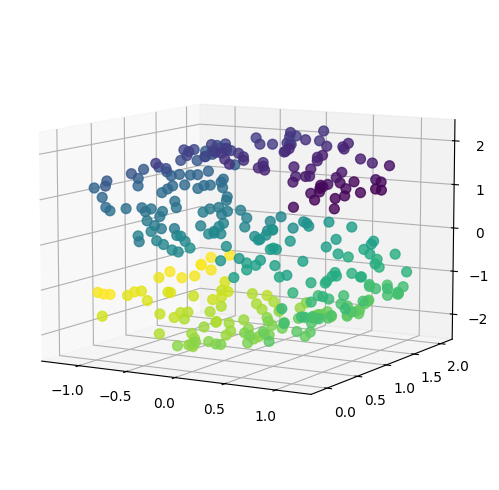

In [20]:
plot_3d(x_te, color_te)

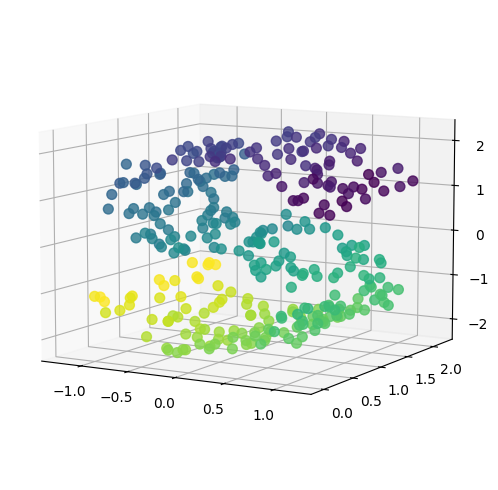

In [16]:
x_re = dpa.reconstruct(x_te, gen_sample_size=1).cpu()
plot_3d(x_re, color_te)

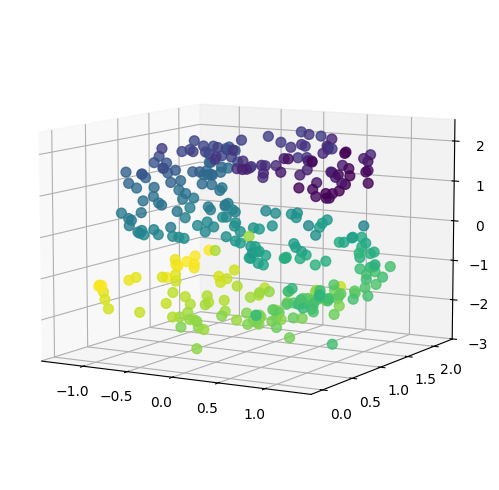

In [17]:
x_re = dpa.reconstruct(x_te, k=2, gen_sample_size=1).cpu()
plot_3d(x_re, color_te)

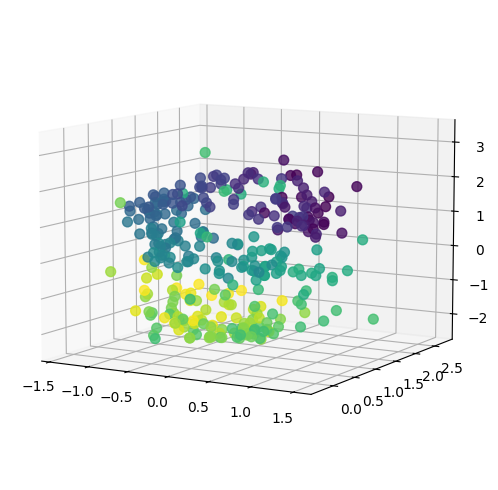

In [18]:
x_re = dpa.reconstruct(x_te, k=1, gen_sample_size=1).cpu()
plot_3d(x_re, color_te)

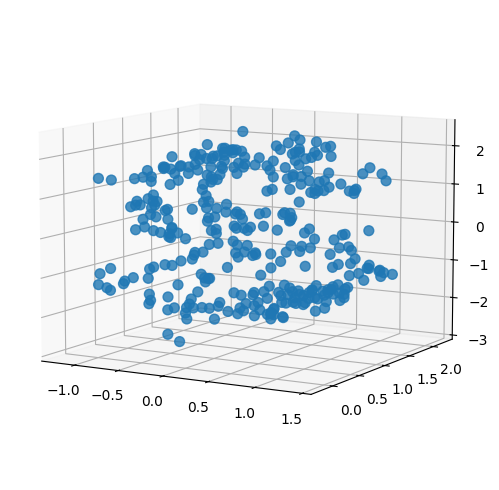

In [19]:
x_re = dpa.reconstruct(x_te, k=2, gen_sample_size=1).cpu()
plot_3d(x_re)